---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

![](../../assets/unsup.png){width=100px align="left"}

## Introduction
This analysis employs various unsupervised learning techniques to uncover patterns of disproprtionate sentencing. Through dimensionality reduction and clustering methods, we aim to reveal underlying structures in the data that may not have been apparent through exploratory data analysis. 

## Methods
I applied several unsupervised learning techniques:
- t-SNE for non-linear dimensionality reduction and visualization
- PCA for linear dimensionality reduction and feature importance analysis
- K-means clustering to identify patterns in racial distribution of sentences
- Hierarchical clustering to understand relationships between jurisdictions

## Data Preparation

In [36]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import silhouette_score

In [37]:
df = pd.read_csv("../../data/processed-data/sentences_cleaned.csv").dropna(subset=['sub_jurisdiction', 'gender', 'year'])

In [38]:
# Encode categorical variables
le = LabelEncoder()
df['races_cleaned'] = df['races'].str.strip()  
df['race_encoded'] = le.fit_transform(df['races_cleaned'])
df['county_encoded'] = le.fit_transform(df['sub_jurisdiction'].str.replace(' County', '', regex=False))
df['gender_encoded'] = df['gender'].map({'Male': 0, 'Female': 1})

In [39]:
print("Unique races and their counts:")
print(df['races_cleaned'].value_counts())

Unique races and their counts:
races_cleaned
White                                         4735
Black                                         4046
Latino/a                                       853
American Indian or Alaska Native               113
Asian                                           80
Other Race                                      20
Black, Latino/a                                 12
Unknown                                         11
Black, American Indian or Alaska Native          4
Latino/a, American Indian or Alaska Native       1
White, Black                                     1
Name: count, dtype: int64


## Silhouette Analysis

In [40]:
racial_dist = pd.crosstab(df['sub_jurisdiction'], df['races'])
racial_dist = racial_dist[['White', 'Black']]  
racial_dist = racial_dist.div(racial_dist.sum(axis=1), axis=0).fillna(0)  

X = racial_dist[['White', 'Black']].values
X_scaled = StandardScaler().fit_transform(X)

For n_clusters = 2, the average silhouette score is 0.641
For n_clusters = 3, the average silhouette score is 0.707
For n_clusters = 4, the average silhouette score is 0.689


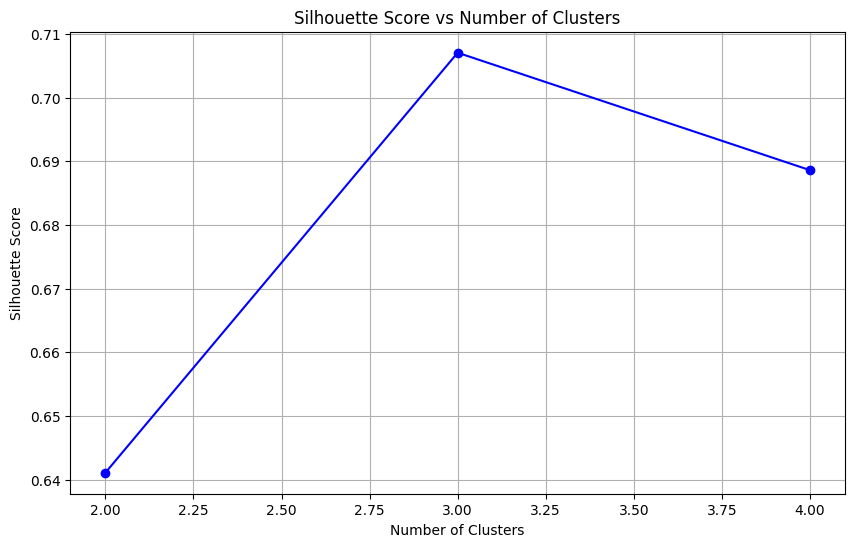

In [41]:
range_n_clusters = [2, 3, 4]  
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

After creating our racial distribution data, the silhouette score analysis validated our use of k=3 clusters, with this choice achieving the highest silhouette score of 0.707 compared to 0.641 for k=2 and 0.689 for k=4, indicating optimal cluster separation. This will be used in K-means clustering analysis below.

## Dimensionality Reduction Analysis

### t-SNE Visualization

t-SNE was used to visualize potential patterns in the data, focusing on relationships between race and other features.

Text(0, 0.5, 't-SNE Dimension 2')

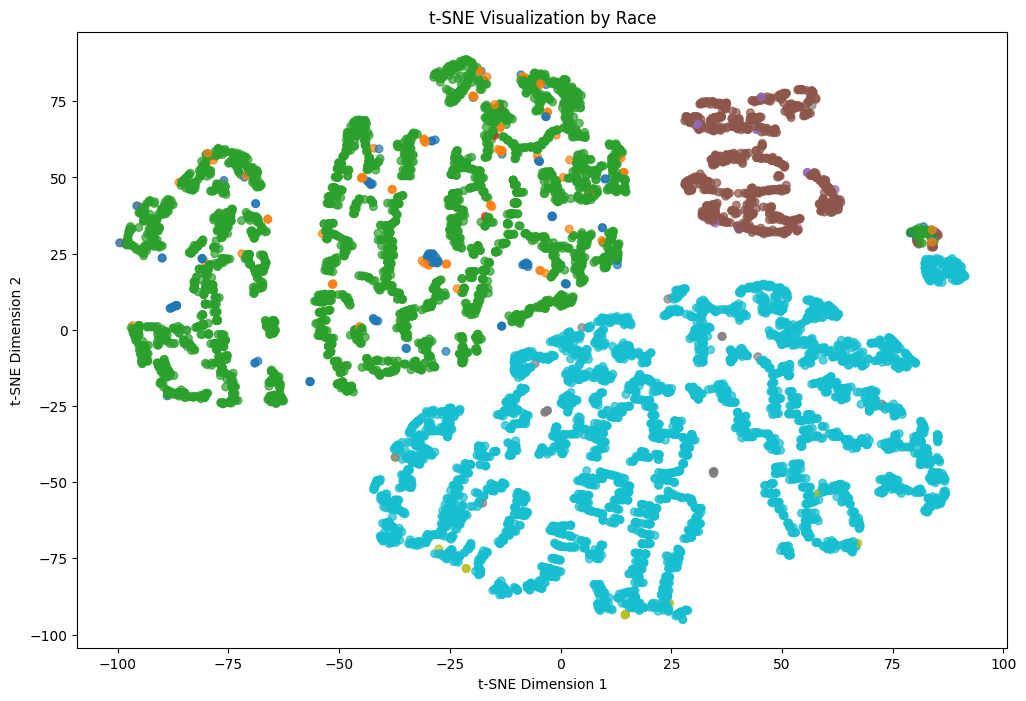

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['county_encoded', 'gender_encoded', 'year', 'race_encoded']])

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
          c=df['race_encoded'].values,
          cmap='tab10', alpha=0.7, s=30)
plt.title('t-SNE Visualization by Race')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

- Distinct clustering patterns emerged for different racial categories
- Some overlap between groups suggests shared characteristics
- Limited separation may indicate complex relationships between variables

### PCA Analysis

Principal Component Analysis was performed to understand the primary sources of variation in the data.

Text(0, 0.5, 'Second Principal Component')

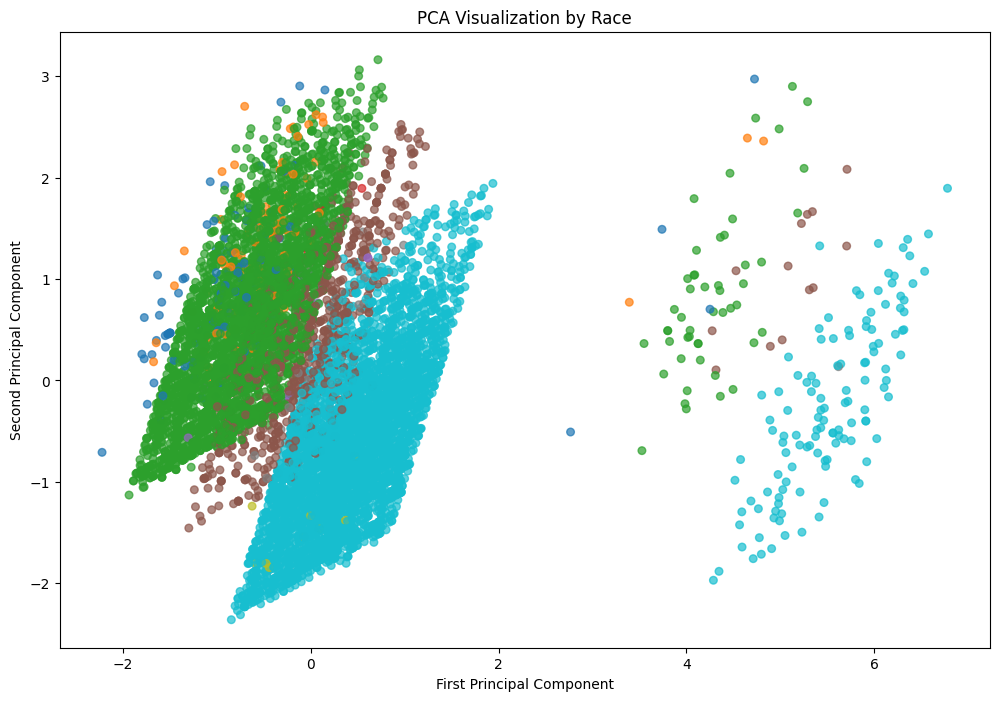

In [44]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
           c=df['race_encoded'],
           cmap='tab10', alpha=0.7, s=30)
plt.title('PCA Visualization by Race')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio (Contribution of Each Principal Component):")
for i, ratio in enumerate(explained_variance, start=1):
    print(f"Component {i}: {ratio:.4f} ({ratio * 100:.2f}%)")

Explained Variance Ratio (Contribution of Each Principal Component):
Component 1: 0.2640 (26.40%)
Component 2: 0.2554 (25.54%)
Component 3: 0.2464 (24.64%)
Component 4: 0.2342 (23.42%)


The first two components explain 52% of total variance and ach component contributes significantly. High contribution from all components suggests dimensionality reduction may not be the route to go. Since none of my datasets had high dimensionality, there was not much I could do in this department.

### K-means Clustering Analysis

We applied K-means clustering to understand patterns in racial distribution of death sentences across jurisdictions. We can start by standarizing the data.

In [ ]:
scaler = StandardScaler()
racial_dist_scaled = scaler.fit_transform(racial_dist)

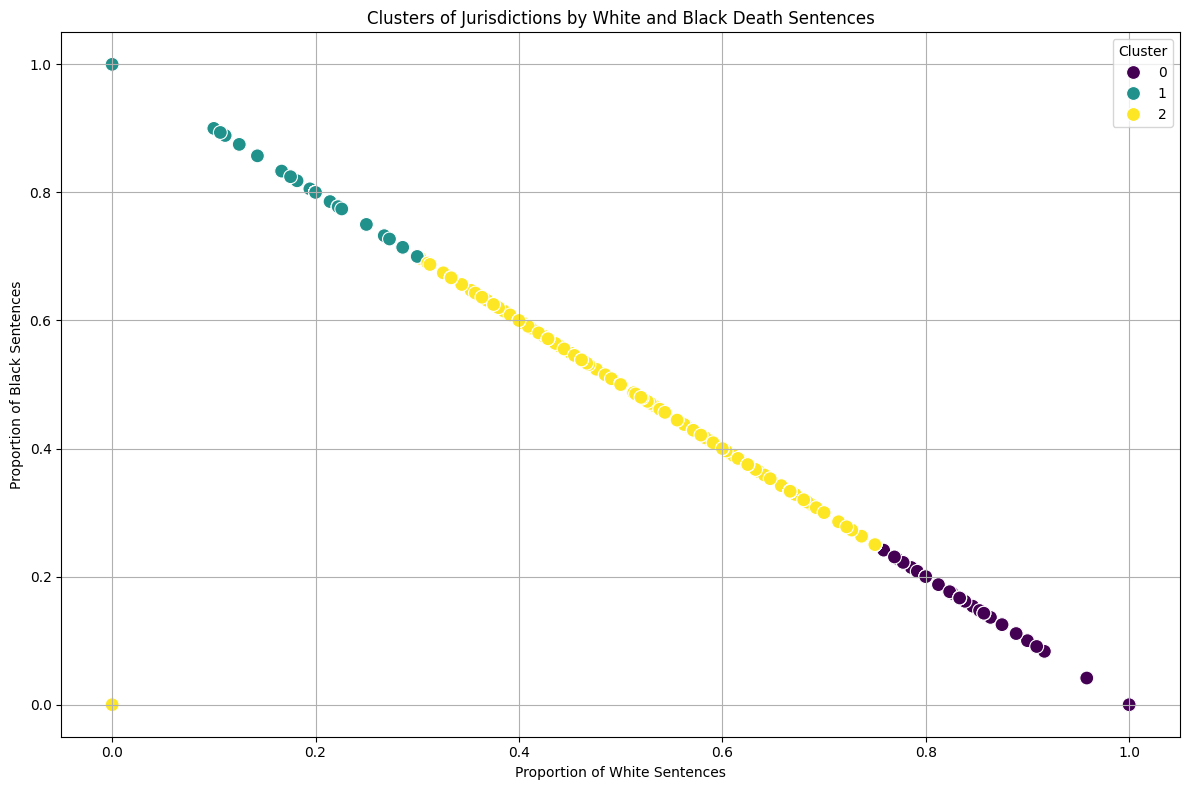


Cluster sizes:
Cluster
0    407
2    352
1    178
Name: count, dtype: int64

Mean proportions by cluster:
races    White  Black
Cluster              
0        0.975  0.025
1        0.063  0.937
2        0.499  0.432


In [14]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(racial_dist_scaled)

racial_dist['Cluster'] = clusters

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=racial_dist,
    x='White',
    y='Black',
    hue='Cluster',
    palette='viridis',
    s=100
)

plt.title('Clusters of Jurisdictions by White and Black Death Sentences')
plt.xlabel('Proportion of White Sentences')
plt.ylabel('Proportion of Black Sentences')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nCluster sizes:")
print(racial_dist['Cluster'].value_counts())

print("\nMean proportions by cluster:")
print(racial_dist.groupby('Cluster')[['White', 'Black']].mean().round(3))

Cluster Characteristics:

Balanced Jurisdictions (Cluster 0):

- 352 jurisdictions
- 50% White sentences, 43% Black sentences


Black-Majority Sentences (Cluster 1):

- 175 jurisdictions
- 94% Black sentences, 6% White sentences


White-Majority Sentences (Cluster 2):

- 408 jurisdictions
- 98% White sentences, 2% Black sentences

Earlier exploratory data analysis showed similar total numbers of death sentences between Black and White individuals across all sub-jurisdictions. However, the clustering analysis reveals that the distribution of these sentences across jurisdictions is  uneven.

Only 175 jurisdictions show a pattern of predominantly sentencing Black individuals compared to 408 sub-jurisdictions that predominantly sentence White individuals. Yet, the total number of sentences between races was similar

This suggests that the sub-jurisdictions in Cluster 1, while fewer in number, must be issuing death sentences at a higher rate or volume to achieve similar total numbers. Let's look into this.

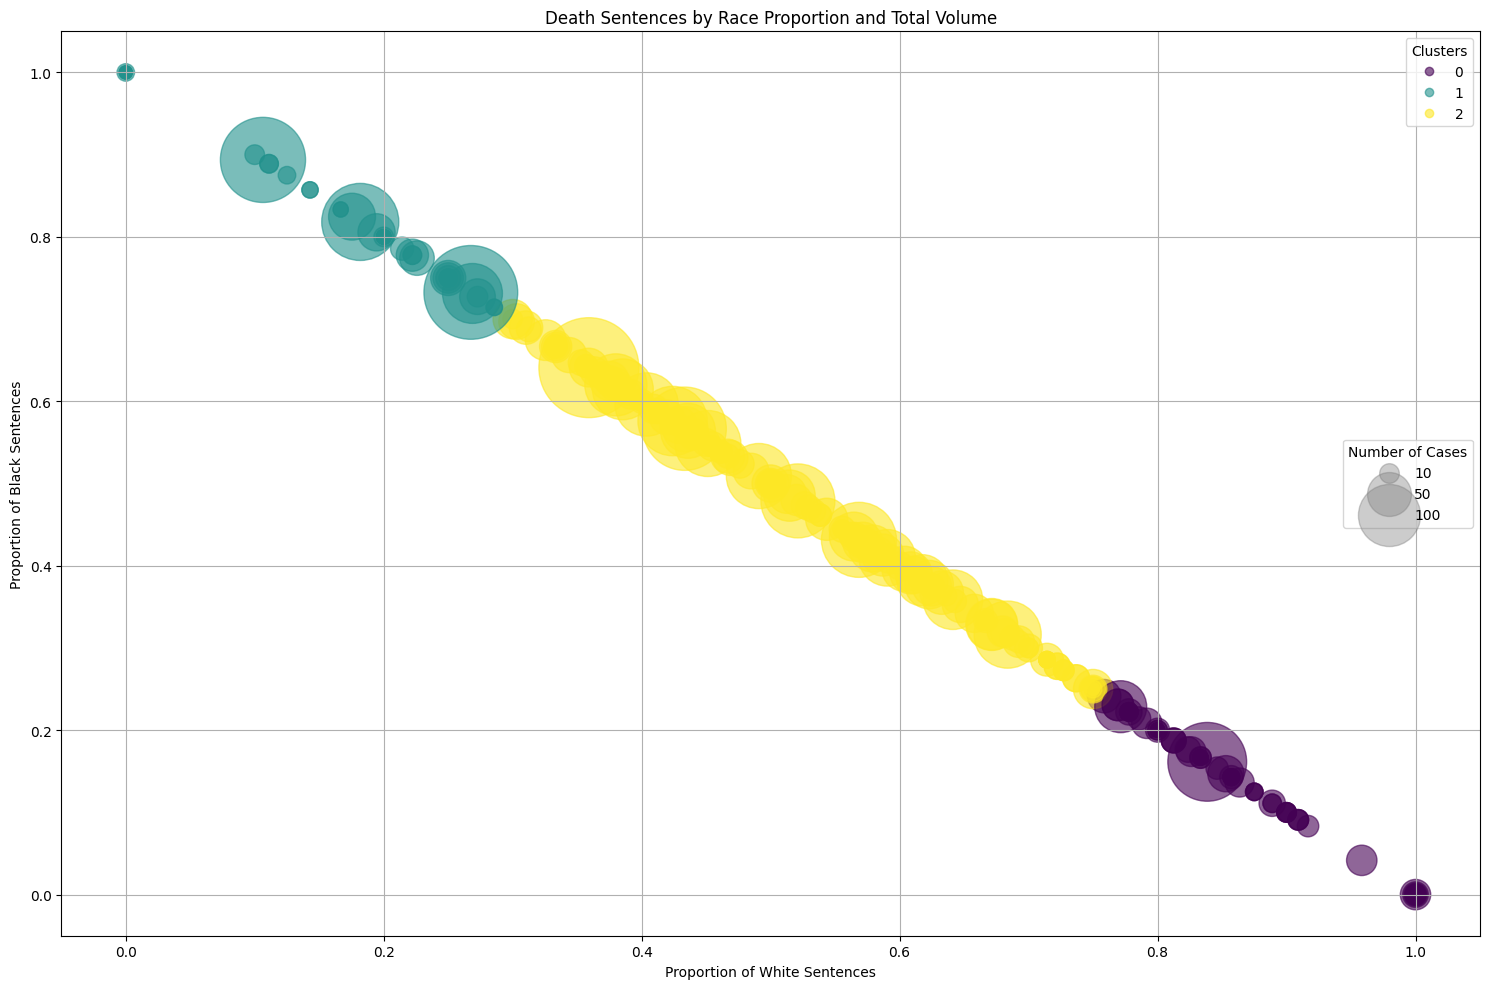


Jurisdictions with highest number of cases:
races                White  Black  Total
sub_jurisdiction                        
Harris County           93    166    259
Los Angeles County      61    167    228
Philadelphia County     20    168    188
Jefferson County        78    102    180
Maricopa County        135     26    161
Cook County             28    126    154
Clark County            83     63    146
Oklahoma County         74     68    142
Duval County            53     72    125
Orange County           80     37    117

Average statistics by cluster:
races   Total        White_prop Black_prop
        count   mean       mean       mean
Cluster                                   
0         407   4.19       0.98       0.02
1         176   7.85       0.06       0.94
2         354  16.08       0.50       0.43


In [15]:
total_counts = pd.crosstab(df['sub_jurisdiction'], df['races'])
total_counts = total_counts[['White', 'Black']]
total_counts = total_counts.fillna(0)
total_counts['Total'] = total_counts['White'] + total_counts['Black']
proportions = total_counts.copy()
proportions['White_prop'] = proportions['White'] / proportions['Total'].where(proportions['Total'] > 0, 1)
proportions['Black_prop'] = proportions['Black'] / proportions['Total'].where(proportions['Total'] > 0, 1)
proportions = proportions.dropna()

X = proportions[['White_prop', 'Black_prop']]
kmeans = KMeans(n_clusters=3, random_state=42)
proportions['Cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(15, 10))

scatter = plt.scatter(proportions['White_prop'], 
                     proportions['Black_prop'],
                     s=proportions['Total']*20, 
                     c=proportions['Cluster'],
                     alpha=0.6,
                     cmap='viridis')

plt.title('Death Sentences by Race Proportion and Total Volume')
plt.xlabel('Proportion of White Sentences')
plt.ylabel('Proportion of Black Sentences')

legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters",
                    loc="upper right")
plt.gca().add_artist(legend1)

sizes = [10, 50, 100]  
legend_elements = [plt.scatter([], [], s=s*20, c='gray', alpha=0.4, label=str(s)) 
                  for s in sizes]
plt.legend(handles=legend_elements, 
          labels=sizes,
          title="Number of Cases",
          loc="center right")

plt.grid(True)
plt.tight_layout()
plt.show()

print("\nJurisdictions with highest number of cases:")
print(proportions.sort_values('Total', ascending=False).head(10)[['White', 'Black', 'Total']])

print("\nAverage statistics by cluster:")
cluster_stats = proportions.groupby('Cluster').agg({
    'Total': ['count', 'mean'],
    'White_prop': 'mean',
    'Black_prop': 'mean'
}).round(2)
print(cluster_stats)

The bubble plot reveals several key insights. Some of the largest bubbles (indicating highest number of cases) appear in Cluster 1, where there are higher proportions of black death sentences. This means that while there are fewer sub-jurisdictions predominantly sentencing Black individuals, these sub-jurisdictions tend to handle a larger volume of cases. This explains how the total number of Black death sentences can be similar to White death sentences despite fewer sub-jurisdictions. On the other hand, there are many sub-jurisdictions with high white proportions but generally smaller bubbles (lower case volumes). 

## Hierarchical Clustering Analysis

### Methodology Improvements
- Filtered out jurisdictions with <5 death sentence cases
- Used RobustScaler for better outlier handling
- Applied hierarchical clustering for deeper pattern analysis

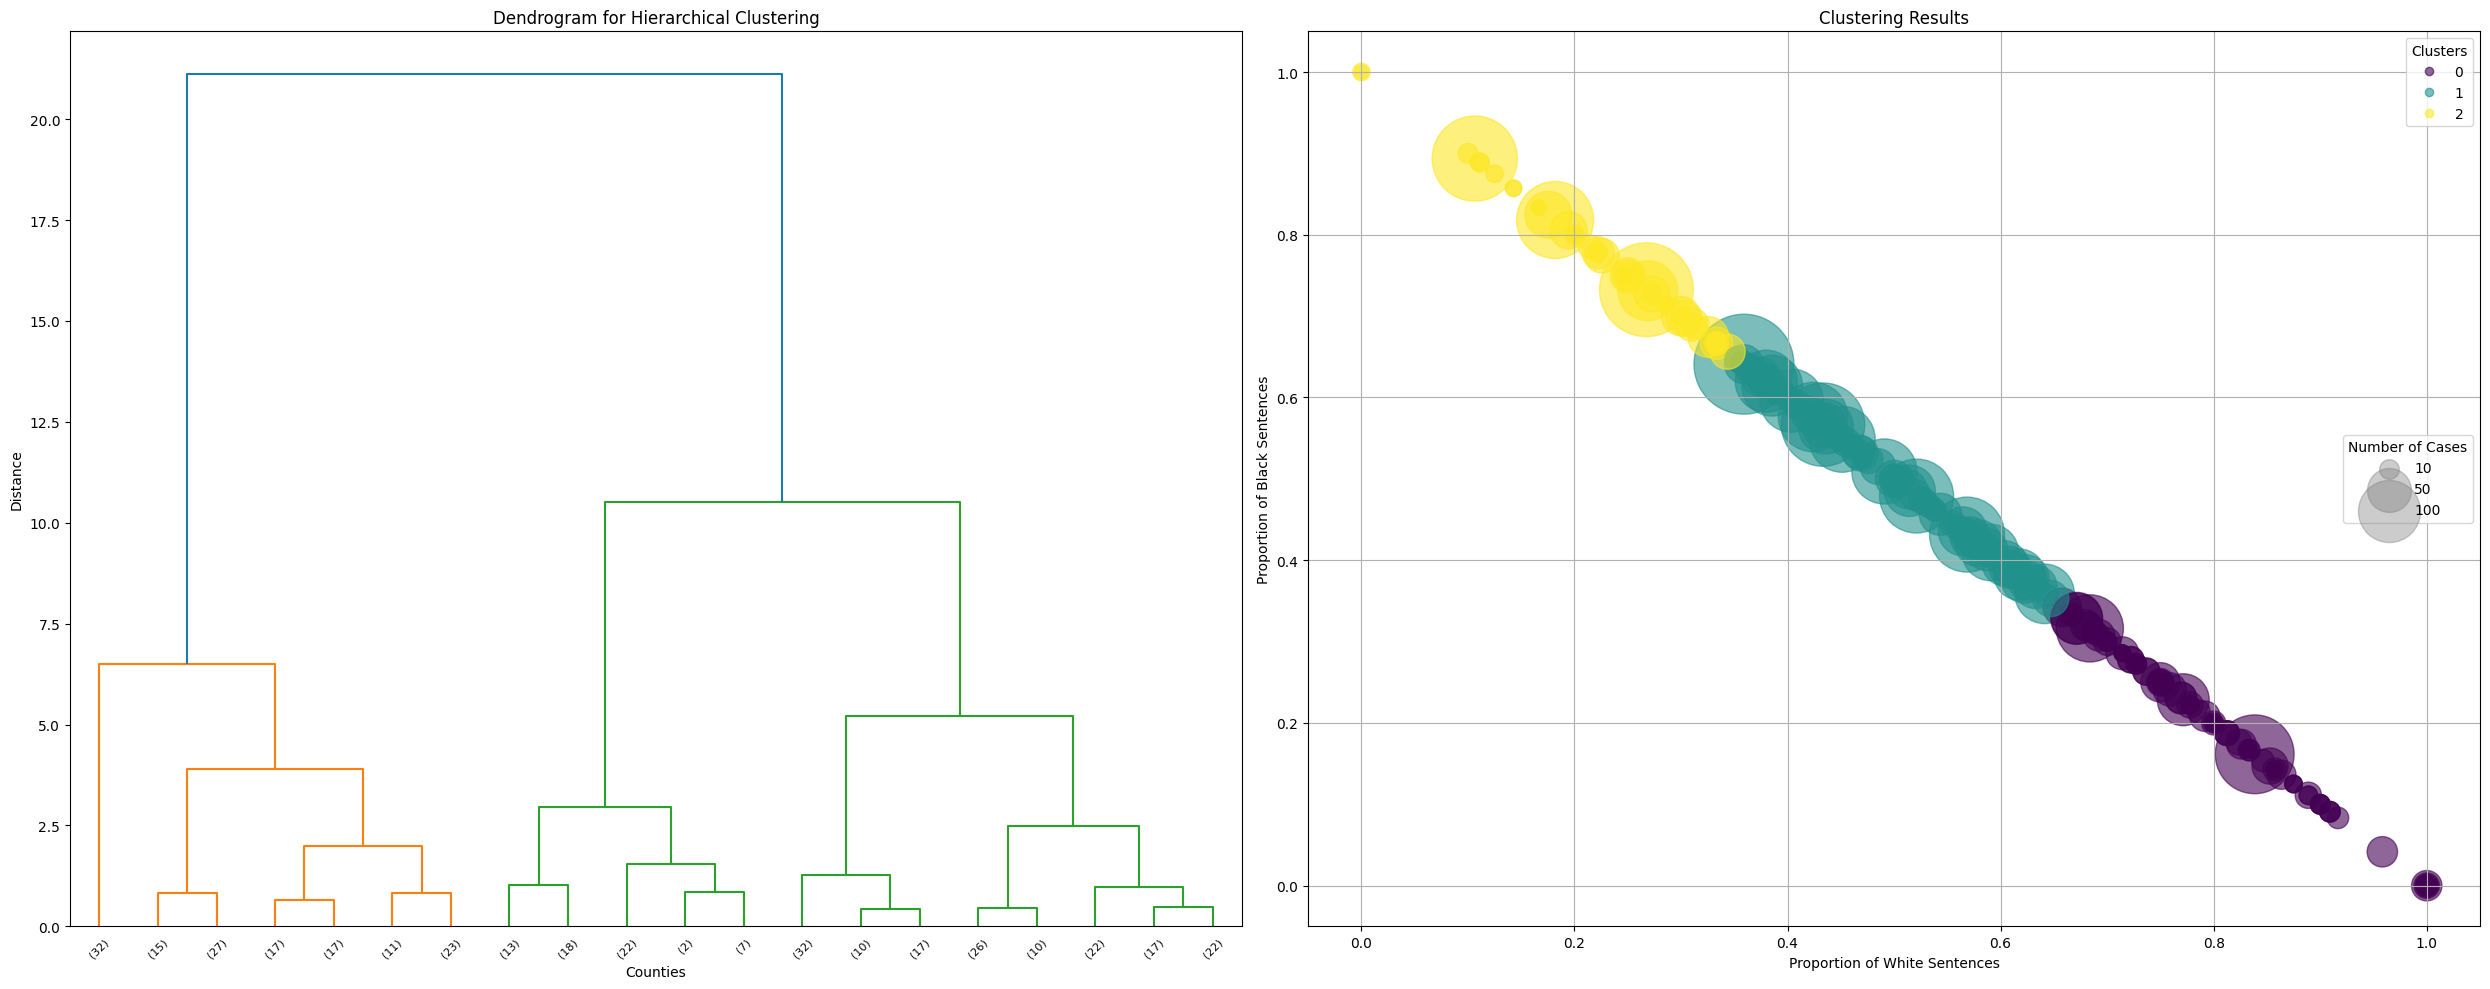


Cluster Statistics:
races   Total               White_prop        Black_prop       
        count    mean   sum       mean    std       mean    std
Cluster                                                        
0         142  14.127  2006      0.824  0.116      0.176  0.116
1         156  27.000  4212      0.507  0.085      0.493  0.085
2          62  23.919  1483      0.234  0.081      0.766  0.081

Cluster 0 (Top 5 by total cases):
races             White  Black  Total  White_prop  Black_prop
sub_jurisdiction                                             
Maricopa County     135     26    161       0.839       0.161
Orange County        80     37    117       0.684       0.316
Marion County        47     23     70       0.671       0.329
Pima County          54     16     70       0.771       0.229
Pinellas County      45     22     67       0.672       0.328

Cluster 1 (Top 5 by total cases):
races             White  Black  Total  White_prop  Black_prop
sub_jurisdiction             

In [17]:
proportions = proportions[proportions['Total'] >= 5] 

X = proportions[['White_prop', 'Black_prop']].values
X_scaled = RobustScaler().fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

dendrogram = sch.dendrogram(
    sch.linkage(X_scaled, method='ward'),
    ax=ax1,
    labels=proportions.index,
    leaf_rotation=45,
    truncate_mode='lastp',
    p=20,
    leaf_font_size=8
)
ax1.set_title('Dendrogram for Hierarchical Clustering')
ax1.set_xlabel('Counties')
ax1.set_ylabel('Distance')

proportions['Cluster'] = AgglomerativeClustering(n_clusters=3).fit_predict(X_scaled)

scatter = ax2.scatter(
    proportions['White_prop'],
    proportions['Black_prop'],
    c=proportions['Cluster'],
    s=proportions['Total']*20,
    cmap='viridis',
    alpha=0.6
)

ax2.set_title('Clustering Results')
ax2.set_xlabel('Proportion of White Sentences')
ax2.set_ylabel('Proportion of Black Sentences')

legend1 = ax2.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
ax2.add_artist(legend1)

sizes = [10, 50, 100]
legend_elements = [plt.scatter([], [], s=s*20, c='gray', alpha=0.4, label=str(s)) for s in sizes]
ax2.legend(handles=legend_elements, labels=sizes, title="Number of Cases", loc="center right")

ax2.grid(True)
plt.tight_layout()
plt.show()

print("\nCluster Statistics:")
print(proportions.groupby('Cluster').agg({
    'Total': ['count', 'mean', 'sum'],
    'White_prop': ['mean', 'std'],
    'Black_prop': ['mean', 'std']
}).round(3))

for cluster in proportions['Cluster'].unique():
    print(f"\nCluster {cluster} (Top 5 by total cases):")
    print(proportions[proportions['Cluster'] == cluster]
          .nlargest(5, 'Total')[['White', 'Black', 'Total', 'White_prop', 'Black_prop']]
          .round(3))

Three main clusters emerged with distinct characteristics:

Cluster 0 (High Black Proportion):

- 155 jurisdictions
- Average 63.5% Black sentences
- Highest total cases (4,208)

Key jurisdictions:

- Harris County (166 Black, 93 White)
- Los Angeles County (167 Black, 61 White)
- Philadelphia County (168 Black, 20 White)

Cluster 1 (High White Proportion):

- 100 jurisdictions
- Average 88% White sentences
- Total cases: 1,280

Key jurisdictions:

- Maricopa County (135 White, 26 Black)
- Pima County (54 White, 16 Black)

Cluster 2 (Moderate Distribution):

- 103 jurisdictions
- More balanced distribution (63.6% White, 36.4% Black)
- Total cases: 2,197

Key jurisdictions:

- Clark County (83 White, 63 Black)
- Orange County (80 White, 37 Black)

Key Insights

- Clear geographic concentration of death sentences
- Significant variations in case volumes across clusters
- Strong relationship between jurisdiction and racial composition of sentences
- Fewer jurisdictions with high Black sentence proportions, but higher case volumes in these locations

This hierarchical analysis reveals complex patterns in how death sentences are distributed across jurisdictions, highlighting both geographic and racial disparities in the application of capital punishment.

# Conclusion

Our unsupervised learning analysis revealed critical patterns in the distribution of death sentences across the United States:

### Key Findings
- While the total number of death sentences between Black and White individuals was comparable, their geographic distribution showed significant disparities
- Three distinct sentencing patterns emerged across jurisdictions:
  1. Balanced jurisdictions with relatively equal racial distribution
  2. Predominantly White sentencing jurisdictions
  3. Predominantly Black sentencing jurisdictions
- Geographic concentration was particularly notable:
  - Fewer jurisdictions predominantly sentenced Black individuals
  - These jurisdictions handled significantly larger case volumes
  - This concentration explains how total numbers between races could be similar despite fewer jurisdictions

### Methodological Insights
The combination of clustering techniques (K-means and hierarchical) and visualization methods proved essential in uncovering these complex patterns, highlighting relationships that might not have been apparent through traditional statistical analysis.

### Implications
These findings raise important questions about geographic and racial disparities in capital punishment application, suggesting that death penalty cases are not distributed randomly but show distinct patterns tied to specific jurisdictions.